Seeding for reproducibility

In [ ]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

Importing the dependency

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models

In [ ]:
!pip install kaggle

In [ ]:
kaggle_credentails = json.load(open("/content/drive/MyDrive/kaggle.json"))

In [ ]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.03G/2.04G [00:23<00:00, 113MB/s]
100% 2.04G/2.04G [00:23<00:00, 92.1MB/s]


In [ ]:
!ls

drive  plantvillage-dataset.zip  sample_data


In [ ]:
# unzip the dataset
with ZipFile("plantvillage-dataset.zip",'r') as zip_ref:
  zip_ref.extractall()

In [ ]:
print(os.listdir("plantvillage dataset"))


print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

['color', 'segmented', 'grayscale']
38
['Tomato___healthy', 'Potato___Late_blight', 'Tomato___Leaf_Mold', 'Cherry_(including_sour)___healthy', 'Apple___Black_rot']
38
['Tomato___healthy', 'Potato___Late_blight', 'Tomato___Leaf_Mold', 'Cherry_(including_sour)___healthy', 'Apple___Black_rot']
38
['Tomato___healthy', 'Potato___Late_blight', 'Tomato___Leaf_Mold', 'Cherry_(including_sour)___healthy', 'Apple___Black_rot']


total 38 classes

Data Preprocessing

In [ ]:
# Dataset Path
base_dir = 'plantvillage dataset/color'

(256, 256, 3)


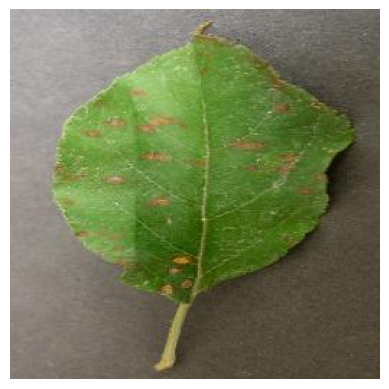

In [ ]:
image_path = '/content/plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [ ]:
image_path = '/content/plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img)

[[[179 175 176]
  [181 177 178]
  [184 180 181]
  ...
  [115 112 105]
  [108 105  98]
  [101  98  91]]

 [[176 172 173]
  [177 173 174]
  [178 174 175]
  ...
  [113 110 103]
  [111 108 101]
  [109 106  99]]

 [[180 176 177]
  [180 176 177]
  [180 176 177]
  ...
  [108 105  98]
  [111 108 101]
  [114 111 104]]

 ...

 [[137 128 119]
  [131 122 113]
  [125 116 107]
  ...
  [ 74  65  48]
  [ 74  65  48]
  [ 73  64  47]]

 [[136 127 118]
  [132 123 114]
  [128 119 110]
  ...
  [ 77  69  50]
  [ 75  67  48]
  [ 75  67  48]]

 [[133 124 115]
  [133 124 115]
  [132 123 114]
  ...
  [ 81  73  54]
  [ 80  72  53]
  [ 79  71  52]]]


In [ ]:
# Image Parameters
img_size = 224
batch_size = 32

**Train Test Split**

In [ ]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [ ]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.


In [ ]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


Concept of Normalization

Convolutional Neural Network

In [ ]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))   # reduces spatial dimensions

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())   # make data 1D
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(train_generator.num_classes, activation='softmax'))    # multiclass classification

In [ ]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [ ]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Training the Model**

In [ ]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/5
1358/1358 [==============================] - 118s 82ms/step - loss: 0.9709 - accuracy: 0.7341 - val_loss: 0.4464 - val_accuracy: 0.8586
Epoch 2/5
1358/1358 [==============================] - 103s 75ms/step - loss: 0.2822 - accuracy: 0.9106 - val_loss: 0.4475 - val_accuracy: 0.8579
Epoch 3/5
1358/1358 [==============================] - 99s 73ms/step - loss: 0.1360 - accuracy: 0.9549 - val_loss: 0.4313 - val_accuracy: 0.8828
Epoch 4/5
1358/1358 [==============================] - 99s 73ms/step - loss: 0.0922 - accuracy: 0.9695 - val_loss: 0.6218 - val_accuracy: 0.8632
Epoch 5/5
1358/1358 [==============================] - 110s 81ms/step - loss: 0.0701 - accuracy: 0.9776 - val_loss: 0.5537 - val_accuracy: 0.8714


The above step will take time.

***Model Evaluation***

In [ ]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
339/339 [==============================] - 18s 54ms/step - loss: 0.5537 - accuracy: 0.8714
Validation Accuracy: 87.14%


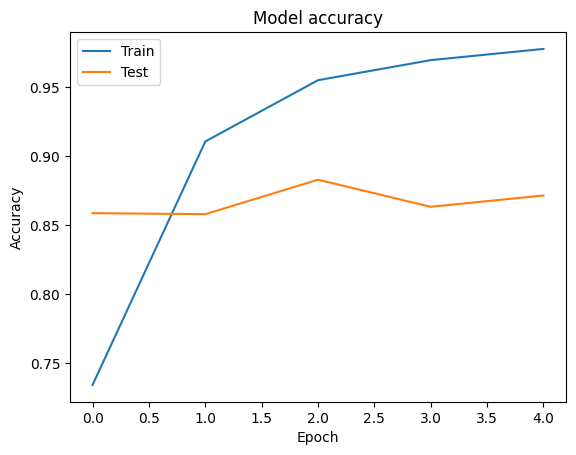

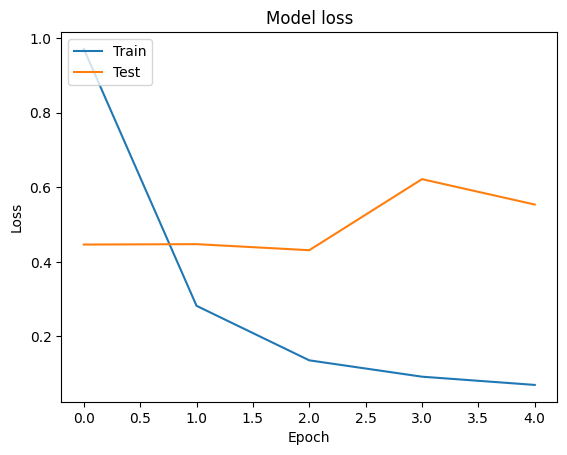

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Building a Predictive System

In [ ]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [ ]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
class_indices
# json file will have 0,1 as string

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

Lets Run and Test

In [ ]:
# Example Usage and Test
image_path = '/content/drive/MyDrive/test_images/test_blueberry_healthy.jpg'
#image_path = '/content/marssonia-leaf-spot-on-euonymus-grabowski.jpg'
#image_path = '/content/test_potato_early_blight.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 17ms/step
Predicted Class Name: Blueberry___healthy


(256, 256, 3)


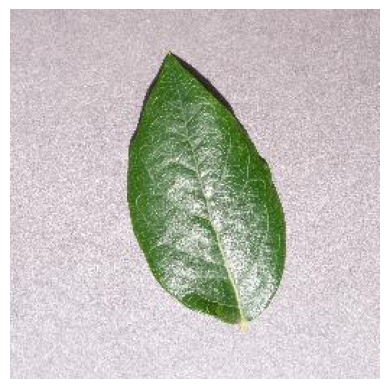

In [ ]:
# Print the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [ ]:
model.save('drive/MyDrive/Plant Disease Prediction.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('Plant Disease Prediction.h5')